## Detecting Hate Speech in Social Media

Here we try to implement the paper

Detecting Hate Speech in Social Media by Shervin Malmasi & Marcos Zampieri

Here is the abstract from the paper

### Abstract

    In this paper we examine methods to detect
    hate speech in social media, while
    distinguishing this from general profanity.
    We aim to establish lexical baselines for
    this task by applying supervised classification
    methods using a recently released
    dataset annotated for this purpose. As features,
    our system uses character n-grams,
    word n-grams and word skip-grams. We
    obtain results of 78% accuracy in identifying
    posts across three classes. Results
    demonstrate that the main challenge lies in
    discriminating profanity and hate speech
    from each other. A number of directions
    for future work are discussed

## We start by importing the necessary libraries and preprocess the data as per the preprocessing steps outlined in the paper

In [1]:
# import necessary libs and setup notebook

import html
import numpy as np
import nltk
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib import pyplot as plt
from nltk.util import skipgrams

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from scipy.sparse import hstack

pd.set_option('display.max_colwidth', 95)
pd.set_option('display.precision', 3)

%matplotlib inline

The data is downloaded from the source given in the paper

https://data.world/crowdflower/hate-speech-identification
    
and placed in the `data` directory


In [2]:
data_file_name = 'data/twitter-hate-speech-classifier-DFE-a845520.csv'
df_raw = pd.read_csv(data_file_name)
df_raw.shape

(14509, 20)

In [3]:
df_raw.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,_created_at,orig__golden,orig__last_judgment_at,orig__trusted_judgments,orig__unit_id,orig__unit_state,_updated_at,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speech_gold_reason,does_this_tweet_contain_hate_speechconfidence,tweet_id,tweet_text
0,853718217,True,golden,86,NaN,The tweet uses offensive language but not hate speech,0.601,NaN,True,NaN,0.0,6.156e+08,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\rThe tweet uses offensive language but not hate speech,NaN,1.0,1.666e+09,Warning: penny boards will make you a faggot
1,853718218,True,golden,92,NaN,The tweet contains hate speech,0.723,NaN,True,NaN,0.0,6.156e+08,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\rThe tweet uses offensive language but not hate speech,NaN,1.0,4.295e+08,Fuck dykes
2,853718219,True,golden,86,NaN,The tweet contains hate speech,0.523,NaN,True,NaN,0.0,6.156e+08,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\rThe tweet uses offensive language but not hate speech,NaN,1.0,3.956e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandonernandez @bootyacid at least i dont look like...
3,853718220,True,golden,98,NaN,The tweet contains hate speech,0.518,NaN,True,NaN,0.0,6.156e+08,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\rThe tweet uses offensive language but not hate speech,NaN,1.0,4.975e+08,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkillah Is a fag"" jackie jealous"" Neeeee"
4,853718221,True,golden,88,NaN,The tweet uses offensive language but not hate speech,0.518,NaN,True,NaN,0.0,6.156e+08,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\rThe tweet uses offensive language but not hate speech,NaN,1.0,5.889e+08,@Zhugstubble You heard me bitch but any way I'm back th texas so wtf u talking about bitch ...


We pick the columns that contains the label and tweet text. The tweet data is converted to unicode string by unescaping html codes.

We also map the values in the `does_this_tweet_contain_hate_speech` column with a shorter label

In [4]:
df = df_raw.loc[:,['does_this_tweet_contain_hate_speech','tweet_text']]
df['does_this_tweet_contain_hate_speech']= df['does_this_tweet_contain_hate_speech'].map({'The tweet uses offensive language but not hate speech': 'offensive',
                                               'The tweet contains hate speech': 'hate',
                                               'The tweet is not offensive' : 'ok'})
df = df.rename(columns={"does_this_tweet_contain_hate_speech": "contains"})
df.tweet_text = df.tweet_text.apply(lambda s:  html.unescape(s))
df.head(15)

,contains,tweet_text
0,offensive,Warning: penny boards will make you a faggot
1,hate,Fuck dykes
2,hate,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandonernandez @bootyacid at least i dont look like...
3,hate,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkillah Is a fag"" jackie jealous"" Neeeee"
4,offensive,@Zhugstubble You heard me bitch but any way I'm back th texas so wtf u talking about bitch ...
5,hate,"@elaynay your a dirty terrorist and your religion is a fucking joke, you go around screamin..."
6,hate,RT @ivanrabago_: @_WhitePonyJr_ looking like faggots?
7,hate,Well I thought you knew actually RT @KingHorseDick: Man why y'all didn't tell me I was a di...
8,offensive,"@Stonisnipezz I know. It was a joke, faggot."
9,offensive,I'm tired of people saying I look like my brother & calling me Deondre' like serious Succ M...


In [5]:
# make sure count is equal to the numbers mentioned in paper
df.contains.value_counts()

ok           7274
offensive    4836
hate         2399
Name: contains, dtype: int64

### We preprocess the tweets to lowercase them and remove all emojis, mentions and urls

In [6]:
## preprocess, lowercase tweets, remove emojis and urls


### convert to lower case
tweet_text = df.tweet_text.str.lower()

### remove urls
tweet_text= tweet_text.str.replace('http\S+|www.\S+', '')

### remove emoji's

def filter_emoji(in_str):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', in_str)

tweet_text= tweet_text.apply(filter_emoji)

## remove mentions
tweet_text= tweet_text.str.replace('@[\w\-]+:?', '')

## remove all non alphabets and punctuations
#tweet_text= tweet_text.str.replace('[^a-zA-z.,!? ]+', '')
tweet_text= tweet_text.str.replace('[\"\']+', '')
#weet_text= tweet_text.str.replace('[^a-zA-z.,!? ]+', '')



X_raw = tweet_text

# convert the labels to numbers
y_raw = df.contains.map({'ok': 0, 'offensive': 1, 'hate': 2})
y = y_raw


tweet_text[:5]

0                                               warning: penny boards will make you a faggot
1                                                                                 fuck dykes
2                                              at least i dont look like jefree starr faggot
3                                                             is a fag jackie jealous neeeee
4     you heard me bitch but any way im back th texas so wtf u talking about bitch ass nigga
Name: tweet_text, dtype: object

### We then extract the features from the tweets using various vectorizers and compare their accuracy score

In [7]:
# extract features

## use a StratifiedKFold cross validataion as stated in the paper
cv = StratifiedKFold(n_splits=10, shuffle=True)
stemmer = PorterStemmer()

stopwords= stopwords.words("english")
other_exclusions = ["ff", "rt"]
stopwords.extend(other_exclusions)

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    #return [token.strip() for token in tweet.split()]
    #tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    #tweet = " ".join(re.split("[^^a-zA-Z.,!?]*", tweet)).strip()
    tweet = " ".join(re.split("[^a-zA-Z#]+", tweet)).strip()
    #tweet = " ".join(re.split("[ ]*", tweet)).strip()
    return tweet.split()

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens



In [8]:
def get_metric(vectorizer, X_raw, y_raw, name):
    """Utility function to fit a classifier and report results given a vectorizer"""
    result={'name':name} 
    y = y_raw
    X = vectorizer.fit_transform(X_raw)
    result['shape'] = X.shape

    aucs = []
    for train, test in cv.split(X, y):
        classifier.fit(X[train], y[train])
        y_preds = classifier.predict(X[test])
        accuracy = accuracy_score(y[test], y_preds)
        aucs.append(accuracy)

    result['accuracies']  = aucs
    result['mean_accuracy'] = np.mean(aucs)
    #result['y_preds'] = y_preds
    return result
    
    
    
#get_metric(vectorizer_3skipbigram, X_raw, y_raw, "3-skip Word bigrams")

### Check the accuracy of various feature extraction methods as given in the paper

In [9]:
## Majority Class Baseline
### This is the accuracy score of test classifier that always predicts the majority class
y_value_counts = y.value_counts()
y_value_counts = y_value_counts.argsort()
majority_class = y_value_counts.iloc[-1]

In [10]:
### check accuracy score for always predicting majority class
y_majority_class = [majority_class] * len(y)
accuracy_score(y, y_majority_class)

0.50134399338341717

In [11]:
## using unigrams

classifier = LinearSVC(C=1)
vectorizer_unigrams = TfidfVectorizer(
    ngram_range=(1,1),
    stop_words=other_exclusions,
    tokenizer=basic_tokenize)

result = get_metric(vectorizer_unigrams, X_raw, y_raw, "Word unigrams")
result

{'accuracies': [0.76308539944903586,
  0.77066115702479343,
  0.76859504132231404,
  0.77548209366391185,
  0.74500344589937972,
  0.77394900068917982,
  0.77103448275862074,
  0.76620689655172414,
  0.75172413793103443,
  0.76259489302967565],
 'mean_accuracy': 0.76483365483196697,
 'name': 'Word unigrams',
 'shape': (14509, 16989)}

In [12]:
## using bigrams
vectorizer_bigrams = TfidfVectorizer(
    ngram_range=(2,2),
    stop_words=other_exclusions,
    tokenizer=basic_tokenize)

result = get_metric(vectorizer_bigrams, X_raw, y_raw, "Word bigrams")
result

{'accuracies': [0.74311294765840219,
  0.73898071625344353,
  0.73829201101928377,
  0.74311294765840219,
  0.7222605099931082,
  0.74293590627153683,
  0.7255172413793104,
  0.72482758620689658,
  0.74068965517241381,
  0.71704623878536922],
 'mean_accuracy': 0.73367757603981665,
 'name': 'Word bigrams',
 'shape': (14509, 84473)}

In [13]:
## using trigrams
vectorizer_trigrams = TfidfVectorizer(
    ngram_range=(3,3),
    stop_words=other_exclusions,
    tokenizer=basic_tokenize)

result = get_metric(vectorizer_trigrams, X_raw, y_raw, "Word trigrams")
result

{'accuracies': [0.68181818181818177,
  0.67355371900826444,
  0.68388429752066116,
  0.66804407713498626,
  0.66643694004135079,
  0.66850447966919369,
  0.67655172413793108,
  0.66551724137931034,
  0.6682758620689655,
  0.67632850241545894],
 'mean_accuracy': 0.67289150251943031,
 'name': 'Word trigrams',
 'shape': (14509, 124965)}

In [14]:
def skipgram_tokenize(tweet, n=None, k=None, include_all=True):
    tokens = [w for w in basic_tokenize(tweet)]
    if include_all:
        result = []
        for i in range(k+1):
            skg = [w for w in skipgrams(tokens, n, i)]
            result = result+skg
    else:
        result = [w for w in skipgrams(tokens, n, k)]
    result=set(result)
    #print(result)
    return result

def make_skip_tokenize(n, k, include_all=True):
    return lambda tweet: skipgram_tokenize(tweet, n=n, k=k, include_all=include_all)

# test for skipgrams
test_str=["test this one two", "test this two three", "test this three four"]
vectorizer_skipgrams = CountVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(2,1))
X_skipgram = vectorizer_skipgrams.fit_transform(test_str)
X_skipgram.toarray()

array([[1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]], dtype=int64)

In [15]:
## using 1-skip bigrams
vectorizer_1skipbigram = TfidfVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(n=2, k=1))
    

result = get_metric(vectorizer_1skipbigram, X_raw, y_raw, "1-skip bigrams")
result

{'accuracies': [0.72038567493112948,
  0.71694214876033058,
  0.72451790633608815,
  0.73760330578512401,
  0.74500344589937972,
  0.72846312887663678,
  0.73448275862068968,
  0.73103448275862071,
  0.73241379310344823,
  0.73360938578329882],
 'mean_accuracy': 0.73044560308547468,
 'name': '1-skip bigrams',
 'shape': (14509, 165841)}

In [16]:
## using 2-skip bigrams
vectorizer_2skipbigram = TfidfVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(n=2, k=2))
    
result = get_metric(vectorizer_2skipbigram, X_raw, y_raw, "2-skip bigrams")
result

{'accuracies': [0.73484848484848486,
  0.72382920110192839,
  0.72658402203856753,
  0.71487603305785119,
  0.73121984838042731,
  0.75740868366643699,
  0.74275862068965515,
  0.7255172413793104,
  0.73724137931034484,
  0.72463768115942029],
 'mean_accuracy': 0.73189211956324263,
 'name': '2-skip bigrams',
 'shape': (14509, 236064)}

In [17]:
## using 3-skip bigrams
vectorizer_3skipbigram = TfidfVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(n=2, k=3))
result = get_metric(vectorizer_3skipbigram, X_raw, y_raw, "3-skip bigrams")
result

{'accuracies': [0.7307162534435262,
  0.72865013774104681,
  0.72933884297520657,
  0.73002754820936644,
  0.72915230875258441,
  0.73259820813232257,
  0.73241379310344823,
  0.7262068965517241,
  0.73448275862068968,
  0.72601794340924775],
 'mean_accuracy': 0.72996046909391621,
 'name': '3-skip bigrams',
 'shape': (14509, 296366)}

In [18]:
## character bigrams
vectorizer_character_bigram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(2,2))
result = get_metric(vectorizer_character_bigram, X_raw, y_raw, "character bigrams")
result

{'accuracies': [0.74380165289256195,
  0.73622589531680438,
  0.73140495867768596,
  0.72865013774104681,
  0.71261199172984147,
  0.7222605099931082,
  0.7448275862068966,
  0.72206896551724142,
  0.73999999999999999,
  0.74879227053140096],
 'mean_accuracy': 0.73306439686065883,
 'name': 'character bigrams',
 'shape': (14509, 2680)}

In [19]:
## character trigrams
vectorizer_character_trigram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(3,3))
result = get_metric(vectorizer_character_trigram, X_raw, y_raw, "character trigrams")
result

{'accuracies': [0.74862258953168048,
  0.77410468319559234,
  0.76170798898071623,
  0.75757575757575757,
  0.75258442453480356,
  0.7622329427980703,
  0.78551724137931034,
  0.76620689655172414,
  0.77655172413793105,
  0.75914423740510695],
 'mean_accuracy': 0.76442484860906934,
 'name': 'character trigrams',
 'shape': (14509, 18186)}

In [20]:
## character 4-grams
vectorizer_character_4gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(4,4))
result = get_metric(vectorizer_character_4gram, X_raw, y_raw, "character 4-grams")
result

{'accuracies': [0.77685950413223137,
  0.76515151515151514,
  0.77134986225895319,
  0.78030303030303028,
  0.75740868366643699,
  0.76292212267401793,
  0.7737931034482759,
  0.76896551724137929,
  0.76068965517241383,
  0.76880607315389926],
 'mean_accuracy': 0.76862490672021522,
 'name': 'character 4-grams',
 'shape': (14509, 63099)}

In [21]:
## character 5-grams
vectorizer_character_5gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(5,5))
result = get_metric(vectorizer_character_5gram, X_raw, y_raw, "character 5-grams")
result

{'accuracies': [0.76515151515151514,
  0.75550964187327818,
  0.75688705234159781,
  0.7692837465564738,
  0.77050310130944177,
  0.75603032391454172,
  0.77172413793103445,
  0.7737931034482759,
  0.75862068965517238,
  0.74948240165631475],
 'mean_accuracy': 0.76269857138376462,
 'name': 'character 5-grams',
 'shape': (14509, 146368)}

In [22]:
## character 6-grams
vectorizer_character_6gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(6,6))
result = get_metric(vectorizer_character_6gram, X_raw, y_raw, "character 6-grams")
result

{'accuracies': [0.75344352617079891,
  0.75137741046831952,
  0.76859504132231404,
  0.76101928374655647,
  0.76154376292212267,
  0.7643004824259132,
  0.76965517241379311,
  0.74344827586206896,
  0.76000000000000001,
  0.76880607315389926],
 'mean_accuracy': 0.76021890284857863,
 'name': 'character 6-grams',
 'shape': (14509, 255630)}

In [23]:
## character 7-grams
vectorizer_character_7gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(7,7))

result = get_metric(vectorizer_character_7gram, X_raw, y_raw, "character 7-grams")
result

{'accuracies': [0.75206611570247939,
  0.75137741046831952,
  0.76308539944903586,
  0.74862258953168048,
  0.74500344589937972,
  0.76361130254996556,
  0.76068965517241383,
  0.74965517241379309,
  0.73448275862068968,
  0.75983436853002073],
 'mean_accuracy': 0.75284282183377782,
 'name': 'character 7-grams',
 'shape': (14509, 365901)}

In [24]:
## character 8-grams
vectorizer_character_8gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(8,8))
result = get_metric(vectorizer_character_8gram, X_raw, y_raw, "character 8-grams")
result

{'accuracies': [0.76239669421487599,
  0.74173553719008267,
  0.721763085399449,
  0.75137741046831952,
  0.76567884217780846,
  0.74638180565127499,
  0.75379310344827588,
  0.73241379310344823,
  0.73103448275862071,
  0.72946859903381644],
 'mean_accuracy': 0.74360433534459713,
 'name': 'character 8-grams',
 'shape': (14509, 466688)}

In [25]:
def get_metric_oracle(X_raw, y_raw, vectorizers):
    results = {"oracle":{}}
    for train, test in cv.split(X_raw, y_raw):
        y_train = y_raw[train]
        X_train = X_raw[train]
        
        y_test = y_raw[test]
        X_test = X_raw[test]
        
        y_pred_oracle = []
        for name in vectorizers:
            vectorizer = vectorizers[name]
            ## initialize result dict
            if name in results:
                result = results[name]
            else:
                result = {}
                results[name] = result
                
         
            
            X_train_tr = vectorizer.fit_transform(X_train)
            
            if not "shape" in result:
                result["shape"] = []
            result['shape'].append(X_train_tr.shape)
            
            classifier.fit(X_train_tr, y_train)
            
            X_test_tr = vectorizer.transform(X_test)
            
            y_preds = classifier.predict(X_test_tr)
            accuracy = accuracy_score(y_test, y_preds)
            
            if not "accuracies" in result:
                result["accuracies"] = []           
            
            result['accuracies'].append(accuracy)
            
            if not "y_preds" in result:
                result["y_preds"] = []
                
            result['y_preds'].append(y_preds)   
            
            y_pred_oracle.append(y_preds)
            
        y_pred_oracle = np.matrix(y_pred_oracle).T
        oracle_correct_pred = 0
        oracle_incorrect_index = []
        for i, yt in enumerate(y_test):
            if True in  (y_pred_oracle[i,:] == yt):
                 oracle_correct_pred += 1
            else:
                oracle_incorrect_index.append(test[i])
                
        accuracy = oracle_correct_pred/len(y_test)
        print("Oracle classifier accuracy={}".format(accuracy))
        result = results["oracle"]
    
        if not "accuracies" in result:
            result["accuracies"] = []           
            
        result['accuracies'].append(accuracy)
        
        if not "oracle_incorrect_index" in result:
            result["oracle_incorrect_index"] = []  
            
        result['oracle_incorrect_index'] = oracle_incorrect_index
    return results
    

In [26]:
vectorizers = {"vectorizer_character_8gram":vectorizer_character_8gram,
              "vectorizer_character_7gram":vectorizer_character_7gram,
              "vectorizer_character_6gram":vectorizer_character_6gram,
              "vectorizer_character_5gram":vectorizer_character_5gram,
              "vectorizer_character_4gram":vectorizer_character_4gram,
              "vectorizer_1skipbigram": vectorizer_1skipbigram,
              "vectorizer_2skipbigram": vectorizer_2skipbigram,
              "vectorizer_3skipbigram": vectorizer_3skipbigram,
              "vectorizer_unigrams": vectorizer_unigrams,
              "vectorizer_bigrams": vectorizer_bigrams,
              "vectorizer_trigrams": vectorizer_trigrams}
               
                 
results = get_metric_oracle(X_raw, y_raw, vectorizers)
#results

Oracle classifier accuracy=0.8760330578512396
Oracle classifier accuracy=0.9042699724517906
Oracle classifier accuracy=0.8842975206611571
Oracle classifier accuracy=0.8994490358126722
Oracle classifier accuracy=0.8980013783597519
Oracle classifier accuracy=0.8911095796002757
Oracle classifier accuracy=0.886896551724138
Oracle classifier accuracy=0.8875862068965518
Oracle classifier accuracy=0.8848275862068965
Oracle classifier accuracy=0.8951000690131125


In [27]:
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [28]:
with open('results.pickle', 'rb') as handle:
    result_read = pickle.load(handle)


In [29]:
incorrect_indexes = sorted(set(result_read["oracle"]["oracle_incorrect_index"]))
print(len(incorrect_indexes))

152


In [30]:
X_incorrect = X_raw[incorrect_indexes]
y_incorrect = y_raw[incorrect_indexes]
incorrect_classified = pd.DataFrame()
incorrect_classified["tweet"] = X_incorrect
incorrect_classified["label"] = y_incorrect
incorrect_classified.head()

,tweet,label
52,"rt young, attractive, successful, supportive, faithful man w his own everything..u think b...",1
63,can i hit that pussy way i wanna while this record playing,1
610,i wonder who prince will look like more. i just know hell have chinks eye shape.,1
918,im a faggot tho. lmfaoooooo,2
975,you guys are faggots and have no lifes and u should just quit in life cause you can do a...,2


In [31]:
incorrect_classified.label.value_counts()

2    88
1    60
0     4
Name: label, dtype: int64

In [32]:
summary = []
for name in result_read:
    result = result_read[name]
    accuracies = result["accuracies"]
    summary.append({"name": name, "accuracy":np.mean(accuracies)})
df_summary = pd.DataFrame(summary)
df_summary

,accuracy,name
0,0.891,oracle
1,0.754,vectorizer_character_8gram
2,0.761,vectorizer_character_7gram
3,0.766,vectorizer_character_6gram
4,0.767,vectorizer_character_5gram
5,0.767,vectorizer_character_4gram
6,0.750,vectorizer_1skipbigram
7,0.750,vectorizer_2skipbigram
8,0.753,vectorizer_3skipbigram
9,0.770,vectorizer_unigrams


In [33]:
def get_metric_combined(X_raw, y_raw, vectorizers):
    accuracies = []
    for train, test in cv.split(X_raw, y_raw):
        y_train = y_raw[train]
        X_train = X_raw[train]
        
        y_test = y_raw[test]
        X_test = X_raw[test]
        
        X_train_combined = None
        X_test_combined = None
        
        for name in vectorizers:
            print("processing {}".format(name))
            vectorizer = vectorizers[name]
            X_train_tr = vectorizer.fit_transform(X_train)
            X_test_tr = vectorizer.transform(X_test)
            #print(X_train_tr.shape)
            #print(X_test_tr.shape)
            
            if X_train_combined is None:
                X_train_combined = X_train_tr
                X_test_combined = X_test_tr
            else:
                t = hstack([X_train_combined, X_train_tr])
                X_train_combined = t
                #print("X_train_combined", X_train_combined.shape)
                t = hstack([X_test_combined, X_test_tr])
                X_test_combined = t
                #print("X_test_combined", X_test_combined.shape)
        #print("X_train_combined", X_train_combined.shape)
        #print("X_test_combined", X_test_combined.shape)
        
        classifier.fit(X_train_combined, y_train)
        y_preds = classifier.predict(X_test_combined)
        accuracy = accuracy_score(y_test, y_preds)
        accuracies.append(accuracy)
        print("accuracy={}".format(accuracy))
    print("Combined classifier mean accuracy={}".format(np.mean(accuracies)))
    return accuracies
        
         

In [34]:
combined_features_scores = get_metric_combined(X_raw, y_raw, vectorizers)
combined_features_scores

processing vectorizer_character_8gram
processing vectorizer_character_7gram
processing vectorizer_character_6gram
processing vectorizer_character_5gram
processing vectorizer_character_4gram
processing vectorizer_1skipbigram
processing vectorizer_2skipbigram
processing vectorizer_3skipbigram
processing vectorizer_unigrams
processing vectorizer_bigrams
processing vectorizer_trigrams
accuracy=0.7630853994490359
processing vectorizer_character_8gram
processing vectorizer_character_7gram
processing vectorizer_character_6gram
processing vectorizer_character_5gram
processing vectorizer_character_4gram
processing vectorizer_1skipbigram
processing vectorizer_2skipbigram
processing vectorizer_3skipbigram
processing vectorizer_unigrams
processing vectorizer_bigrams
processing vectorizer_trigrams
accuracy=0.7796143250688705
processing vectorizer_character_8gram
processing vectorizer_character_7gram
processing vectorizer_character_6gram
processing vectorizer_character_5gram
processing vectorizer_ch

[0.76308539944903586,
 0.77961432506887052,
 0.7816804407713499,
 0.7658402203856749,
 0.76567884217780846,
 0.76705720192970361,
 0.76689655172413795,
 0.75724137931034485,
 0.76827586206896548,
 0.76949620427881293]

### We check the learning curve of our best model ( character 4-gram)

(14509, 63099)
train_sizes [ 1305  2145  2984  3823  4663  5502  6341  7181  8020  8860  9699 10538
 11378 12217 13057]


<module 'matplotlib.pyplot' from '/home/tutysara/anaconda2/envs/dog-project/lib/python3.6/site-packages/matplotlib/pyplot.py'>

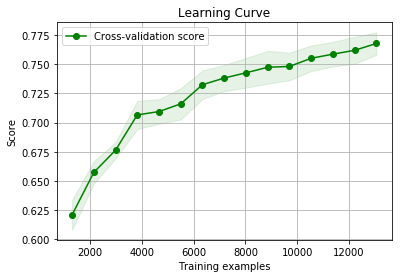

In [35]:
## this is based on example code from sklearn documentation, adapted to our use
### can be found at http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1, 15)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    print(X.shape)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=0)
    print("train_sizes", train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X_train_tr = vectorizer_character_4gram.fit_transform(X_raw)
plot_learning_curve(classifier, "Learning Curve", X_train_tr, y_raw, cv=cv, n_jobs=1)

In [36]:
from sklearn.metrics import confusion_matrix

X_tr = vectorizer_character_4gram.fit_transform(X_raw)
classifier.fit(X_tr, y_raw)
y_preds = classifier.predict(X_tr)
cnf_matrix = confusion_matrix(y_raw, y_preds)
cnf_matrix   

array([[7242,   22,   10],
       [  64, 4576,  196],
       [  20,  271, 2108]])

In [37]:
train, test = next(cv.split(X_raw, y_raw))

y_train = y_raw[train]
X_train = X_raw[train]

y_test = y_raw[test]
X_test = X_raw[test]

X_train_tr = vectorizer_character_4gram.fit_transform(X_train)
X_test_tr = vectorizer_character_4gram.transform(X_raw)
    
classifier.fit(X_train_tr, y_train)
y_preds = classifier.predict(X_test_tr)
cnf_matrix = confusion_matrix(y_raw, y_preds)
accuracy = accuracy_score(y_raw, y_preds)
accuracy   

0.94417258253497827

In [38]:
### code based on example code at --http://scikit-learn.org/stable/auto_examples/model_selection/
### plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[7207   49   18]
 [ 116 4471  249]
 [  35  343 2021]]


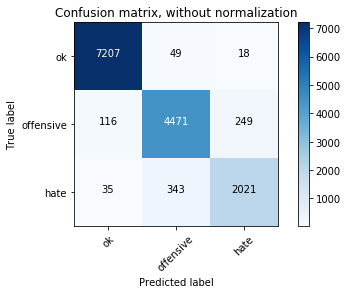

Normalized confusion matrix
[[ 0.99078911  0.00673632  0.00247457]
 [ 0.02398677  0.9245244   0.05148883]
 [ 0.01458941  0.14297624  0.84243435]]


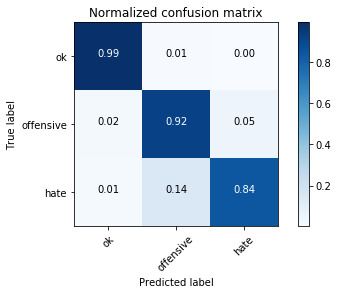

In [39]:
# Plot normalized confusion matrix
class_names = ["ok", "offensive", "hate"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### Some examples from each category

#### Hate classified as Hate

In [40]:
HATE = 2
OFFENSIVE = 1
OK = 0

def print_sample(true_label, pred_label, take_n=5):
    counter = 1
    for i, item in enumerate(zip(y_raw,y_preds)):
        t,p = item
        if t== true_label and p == pred_label:
            print(X_raw[i].strip())
            counter += 1
            if counter > take_n:
                break
                
print_sample(HATE, HATE)

fuck dykes
at least i dont look like jefree starr faggot
is a fag jackie jealous neeeee
your a dirty terrorist and your religion is a fucking joke, you go around screaming allah akbar doing terrorist shit. dirty faggot.
rt   looking like faggots?


#### Hate classified as offensive

In [41]:
print_sample(HATE, OFFENSIVE)

well i thought you knew actually rt  man why yall didnt tell me i was a dick riding ass faggot? yall not real
if trump is recruiting fr is hes actually doin intelligence officers job, isnt he? hes diggin those bastard sympathisers outta der cells
got tired of niggas fuckin my shit up i had to come fuck wit da chinks $8 i dont care what they do
stop taking a shit faggot
_ã¢ûòìê pandora-sissy: my new site - pandora sissy love xoxoxo smallclitsissy.com #sissy #faggot...


#### Offensive classified as Hate

In [42]:
print_sample(OFFENSIVE, HATE)

i know. it was a joke, faggot.
are you gonna call my mommy on me?....fuckin faggot.
faggot
faggots
faggots are gay


#### Offensive classified as Offensive

In [43]:
print_sample(OFFENSIVE, OFFENSIVE)

you heard me bitch but any way im back th texas so wtf u talking about bitch ass nigga
im tired of people saying i look like my brother & calling me deondre like serious succ my ass fag asses
i cant stand no crybaby ass nigga. if you gonna act like a bitch i will leave yo ass after i instavideo yo stupid lookin ass
ill fuck you til you love me faggot - mike tyson


### Future Work

### Try out Ensemble classifier based on voting

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(random_state=5)
clf2 = RandomForestClassifier(random_state=5)
clf3 = MultinomialNB()
clf4 = LinearSVC()

eclf1 = VotingClassifier(estimators=[
        ('lr', clf1),  ('mnb', clf3), ('lrsvc', clf4)], voting='hard')
    #('lr', clf1), ('gnb', clf3)], voting='hard')

aucs = []
for train, test in cv.split(X_raw, y_raw):
    y_train = y_raw[train]
    X_train = X_raw[train]

    y_test = y_raw[test]
    X_test = X_raw[test]

    X_train_tr = vectorizer_character_4gram.fit_transform(X_train)
    X_test_tr = vectorizer_character_4gram.transform(X_test)
    
    eclf1 = eclf1.fit(X_train_tr, y_train)
    y_preds = eclf1.predict(X_test_tr)
    accuracy = accuracy_score(y_test, y_preds)
    aucs.append(accuracy)
    print(accuracy)

result['accuracies']  = aucs
result['mean_accuracy'] = np.mean(aucs)
#result['y_preds'] = y_preds
print("mean_accuracy", result['mean_accuracy'])

0.748622589532
0.75826446281
0.769972451791
0.754132231405
0.757408683666
0.751895244659
0.770344827586
0.768965517241
0.749655172414
0.753623188406
mean_accuracy 0.758288436951


## Out of paper work
### Try NBSVM classifier

In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [77]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1).fit(X_train_tr, y_train)

In [78]:
y_pred = model.predict(X_test_tr)

In [102]:
aucs = []
for train, test in cv.split(X_raw, y_raw):
    y_train = y_raw[train]
    X_train = X_raw[train]

    y_test = y_raw[test]
    X_test = X_raw[test]

    X_train_tr = vectorizer_character_4gram.fit_transform(X_train)
    X_test_tr = vectorizer_character_4gram.transform(X_test)
    
    model = NbSvmClassifier(C=4, dual=True, n_jobs=-1).fit(X_train_tr, y_train)
    y_preds = model.predict(X_test_tr)
    accuracy = accuracy_score(y_test, y_preds)
    aucs.append(accuracy)
    print(accuracy)
result['accuracies']  = aucs
result['mean_accuracy'] = np.mean(aucs)
#result['y_preds'] = y_preds
print("mean accuracy", result['mean_accuracy'])

0.780303030303
0.79476584022
0.778925619835
0.802341597796
0.778773259821
0.790489317712
0.791724137931
0.793103448276
0.766206896552
0.786749482402
mean accuracy 0.786338263085


### Conclusion

- We preprocessed the data and transformed it according to the methods stated in the paper
- We have covered all the different vectorizers outlined in the paper and extracted many different set of features from the data
- We wrote few utility methods to cover things like skipgrams
- We executed the classifier on all feature sets and listed the scores of all classifiers
- We implemented the baseline and oracle classifier
- We implemented a combined classifier that uses all features from all vectorizers
- We implemented the learning curve and found the effect of adding data on the classifier
- We plotted the confusion matrix
- We displayed some sample tweets from each of the groups of interest (Hate and Offensive) that are both correctly and incorrectly classified
- We implemented an ensemble classifier which is mentioned in the future work
